# Reinforcement Learning Code, part 4: Model-based RL

In model-based RL, the agent has an internal model of the environment, and uses the internal model to update its $Q$-value functions.

## One-step $Q$-planning

The simplest example of model-based RL is one-step $Q$-planning (1SQP).  In 1SQP, the agent fills in its own $Q$-tables by simulating the environment multiple times. 

In [1]:
import random
import numpy as np
from copy import copy
import matplotlib.pyplot as plt 

class Maze():
    """A maze environment"""

    ACTIONS = ("up", "down", "left", "right") # List of actions
    INITIAL_STATE = (0, 0) # Always starts at the topleft corner
    
    def __init__(self, fname = "grid.txt"):
        """Inits a maze by loading the grid file"""
        self.grid = np.loadtxt(fname)
        self.state = self.INITIAL_STATE
        self.end = False


    def state_transition(self, state1, action1):
        "Defines the next state gien the "
        s = state1
        state2 = copy(state1)
        
        if action1 in self.ACTIONS:
            if action1 == "up":
                if s[0] > 0:
                    state2 = (s[0] - 1, s[1])
            
            elif action1 == "left":
                if s[1] > 0:
                    state2 = (s[0], s[1] - 1)
            
            elif action1 == "down":
                if s[0] < (self.grid.shape[0] - 1):
                    state2 = (s[0] + 1, s[1])

            elif action1 == "right":
                if s[1] < (self.grid.shape[1] - 1):
                    state2 = (s[0], s[1] + 1)
                    
        return state2
                    
    
    def reward_transition(self, state1, action1, state2):
        """Reward is -1 for bouncing against the walls, and whatever is on the grid otherwise"""
        if state1 == state2:
            return -1
        else:
            return self.grid[state2[0], state2[1]]
        
    
    # Quick way to combine State transitions and Reward transitions 
    def transition(self, action1):
        """Changes the state following an action"""
        state1 = self.state
        state2 = self.state_transition(state1, action1)
        reward2 = self.reward_transition(state1, action1, state2)
        
        self.state = state2
        return (state2, reward2) # Returns s_t+1, r_t+1

    
    def print_state(self):
        "Prints a text representation of the maze (with the agent position)"
        bar = "-" * ( 4 * self.grid.shape[1] + 1)
        for i in range(self.grid.shape[0]):
            row = "|"
            for j in range(self.grid.shape[1]):
                cell = " "
                if i == self.state[0] and j == self.state[1]:
                    cell = "*"
                row += (" %s |" % cell)
            print(bar)
            print(row)
        print(bar)

## The MB-Agent

And now, the agent. In addition to the $Q$-table, the new agent has a model of the environment. The model will be represented as an $S$-table, a table of $(s_t, a_t)$ associations with the consequences $(s_{t+1}, r_{t+1})$. The model needs to have an internal model of the enviroment (the $S$-table) to start with. The table is created by passing the environment to an agent's function called `initS`. 

In [5]:
import random
import numpy as np

class MBAgent():
    def __init__(self, actions=Maze.ACTIONS, epsilon=0.1, alpha=0.1, gamma=0.9):
        """Creates a Q-agent"""
        self.Q = {}    ## Initial dictionary of (s, a) pairs. At the beginning, it's emtpy.
        self.S = {}
        self.epsilon = epsilon     # Epsilon for e-greey policy
        self.alpha = alpha         # Learning rate
        self.gamma = gamma         # Temporal discounting
        self.actions = actions     # Set of possible actions (provide those of Maze.ACTIONS)
        
        
    def initS(self, environment = Maze()):
        """Initializes the model of the environment"""
        states = [(row, col) for row in range(4) for col in range(4)]
        actions = self.actions
        
        # All possible transitions
        for state1 in states:
            for action1 in actions:
                # For every state and every action, predict the consequence
                state2 = environment.state_transition(state1, action1)
                reward2 = environment.reward_transition(state1, action1, state2)
                
                # Update the S-table
                self.S[(state1, action1)] = (state2, reward2)
        

    def qplanning(self, n=1000):
        """Plans ahead and learns the Q-table"""
        for j in range(n):
            start = random.choice(tuple(self.S.keys()))
            state2, reward2 = self.S[start]
            action2 = random.choice(self.actions)
            state1, action1 = start
            self.learnQ(state1, action1, reward2, state2, action2)

        
    def policy(self, state):
        """Selects an action with a epsilon-greedy policy"""
        if random.random() < self.epsilon:
            action = random.choice(self.actions)
        else:
            q = [self.Q[(state, a)] if (state, a) in self.Q.keys() else 0.0 for a in self.actions]
            maxQ = max(q)
            count = q.count(maxQ)
            if count > 1:
                best = [i for i in range(len(self.actions)) if q[i] == maxQ]
                i = random.choice(best)
            else:
                i = q.index(maxQ)

            action = self.actions[i]
        return action

    
    def learnQ(self, state1, action1, reward2, state2, action2):
        """Updates the Q-values when given an (s,a) pair, the reward value and a new state"""
        g = self.gamma
        a = self.alpha
        
        q1 = 0.0
        
        if (state1, action1) in self.Q.keys():
            q1 = self.Q[(state1, action1)]
        
        max_q2 = max([self.Q[(state2, a)] if (state2, a) in self.Q.keys() else 0.0 for a in self.actions])
        
        rpe = reward2 + g * max_q2 - q1
        #print("s1 = %s, a1 = %s, s2 = %s, q1 = %.4f, r2 = %.4f, q2 = %.4f" % (state1, action1, state2, q1, reward2, max_q2))
        q1 += a * rpe
        #print("new q1 = %.4f" % (q1,))
        self.Q[(state1, action1)] = q1

            
    def visualizeQ(self, vmin=-1, vmax=10):
        """Visualizes the Q tables, one per action"""
        for a in self.actions:
            # Create the corresponding state table
            mat = np.zeros((4,4))
            states = [x for x in self.Q.keys() if x[1] == a]
            
            for s in states:
                row, col = s[0]
                mat[row, col] = self.Q[s]
            
            # Show the Q-table as a heatmap
            plt.imshow(mat, interpolation = "none", vmin=vmin, vmax=vmax, cmap='viridis')
            plt.title("Q-Table for action '%s'" % a.upper())
            plt.show()

## Interactions between environment and agent

The interactions are managed by the usual functions, `run_trial` and `run_trials`.

In [8]:
def run_trial(environment, agent):
    """A trial ends when the agent gets a reward. The history is returned"""
    state1 = environment.state
    action1 = agent.policy(state1)
    reward2 = 0.0
    history = [state1]
    while reward2 != 10:
        state2, reward2 = environment.transition(action1)
        action2 = agent.policy(state2)
        
        # Save the states visited
        history.append(state2)
        
        # Update the Q-values for state1, action1
        agent.learnQ(state1, action1, reward2, state2, action2)
        
        state1 = state2
        action1 = action2
        
    return history

    
def run_trials(environment, agent, n, collect=True):
    """Runs N trials"""
    history = []
    for j in range(n):
        h = run_trial(environment, agent)
        history += h
        environment.state = Maze.INITIAL_STATE
    
    return history
        
def visualize_history(history, title="Preferred path"):
    mat = np.zeros((4,4))            
    for s in history:
        row, col = s
        mat[row, col] += 1
    
    mat /= np.sum(mat)
    mat *= 5  # min number of moves
    
    plt.imshow(mat, interpolation = "none", vmin=0, vmax=1, cmap='inferno')
    plt.title(title)
    plt.show()

## Testing the Model-Based Agent 

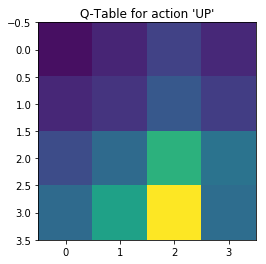

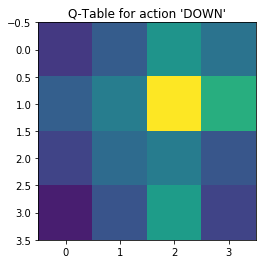

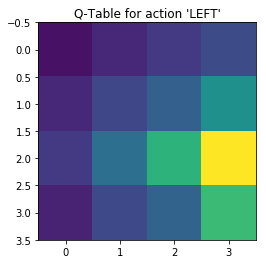

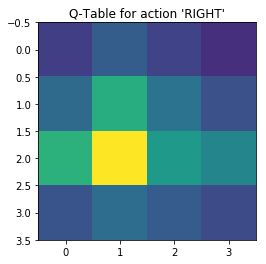

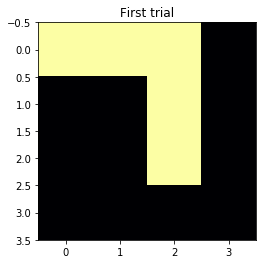

In [11]:
m = Maze()
a = MBAgent()
a.initS(m)
a.qplanning(n=1000)

# Before the agent starts, it has perfect knowledge
a.visualizeQ()

# Very first trial
h = run_trials(m, a, 1)
visualize_history(h, "First trial")

## Dyna-Q

The One-step Q-planning agent needs an internal model of the environment to start with. But what if the environment can be learned as we go? The idea is known as Dyna-$Q$. In this new agent, there is no neeed to intialize the internal model with a special function `initS`. Instead, the code to update the $S$-table is directly embedded into the `learnQ` function.  

In [57]:
import random
import numpy as np

class DynaQ():
    def __init__(self, actions=Maze.ACTIONS, epsilon=0.1, alpha=0.1, gamma=0.9):
        """Creates a DynaQ-agent. Note that this agent learns the S-table as it explores"""
        self.Q = {}    ## Initial dictionary of (s, a) pairs. At the beginning, it's emtpy.
        self.S = {}    ## Initial model of the environment. At the beginning,  it's empty. 
        self.epsilon = epsilon     # Epsilon for e-greey policy
        self.alpha = alpha         # Learning rate
        self.gamma = gamma         # Temporal discounting
        self.actions = actions     # Set of possible actions (provide those of Maze.ACTIONS)

        
    def qplanning(self, n=10):
        """Plans ahead and learns the Q-table"""
        if len(self.S.keys()) > 0:
            for j in range(n):
                start = random.choice(tuple(self.S.keys()))
                state2, reward2 = self.S[start]
                action2 = random.choice(self.actions)
                state1, action1 = start
                self.learnQ(state1, action1, reward2, state2, action2)

        
    def policy(self, state):
        """Selects an action with a epsilon-greedy policy"""
        # First, plan ahead with the basic environment as we know it
        self.qplanning(n=10)
        
        # Then, proceed with selecting an action
        if random.random() < self.epsilon:
            action = random.choice(self.actions)
        else:
            q = [self.Q[(state, a)] if (state, a) in self.Q.keys() else 0.0 for a in self.actions]
            maxQ = max(q)
            count = q.count(maxQ)
            if count > 1:
                best = [i for i in range(len(self.actions)) if q[i] == maxQ]
                i = random.choice(best)
            else:
                i = q.index(maxQ)

            action = self.actions[i]
        return action

    
       
    
    def learnQ(self, state1, action1, reward2, state2, action2):
        """Updates the Q-values when given an (s,a) pair, the reward value and a new state"""
        g = self.gamma
        a = self.alpha
        
        q1 = 0.0
        
        if (state1, action1) in self.Q.keys():
            q1 = self.Q[(state1, action1)]
        
        max_q2 = max([self.Q[(state2, a)] if (state2, a) in self.Q.keys() else 0.0 for a in self.actions])
        
        rpe = reward2 + g * max_q2 - q1
        q1 += a * rpe
        
        # Update the Q-table
        self.Q[(state1, action1)] = q1
        
        # Update the S-table
        if (state1, action1) in self.S.keys():
            self.S[(state1, action1)] = (state2, reward2)

            
    def visualizeQ(self, vmin=-1, vmax=10):
        """Visualizes the Q tables, one per action"""
        for a in self.actions:
            # Create the corresponding state table
            mat = np.zeros((4,4))
            states = [x for x in self.Q.keys() if x[1] == a]
            
            for s in states:
                row, col = s[0]
                mat[row, col] = self.Q[s]
            
            # Show the Q-table as a heatmap
            plt.imshow(mat, interpolation = "none", vmin=vmin, vmax=vmax, cmap='jet')
            plt.title("Q-Table for action '%s'" % a.upper())
            plt.show()

### Testing Dyna-$Q$

Here is a simple test of Dyna-$Q$. Note that the new agent learns as it goes, but learns faster than a simple Q-agent.

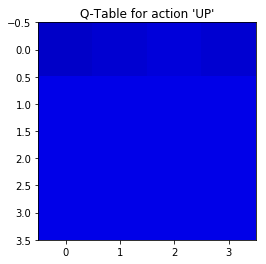

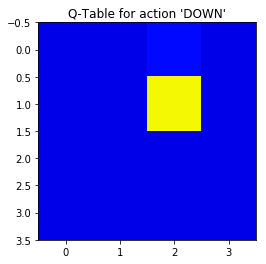

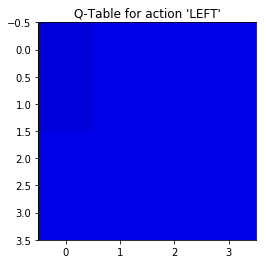

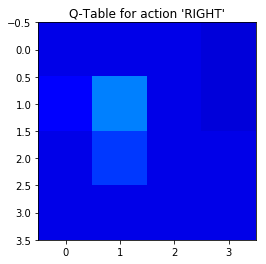

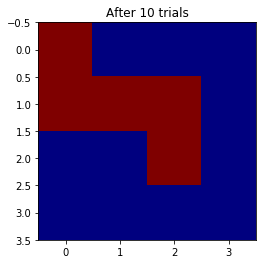

In [60]:
m = Maze()
a = DynaQ()

run_trials(m, a, 10)
a.visualizeQ()
h = run_trials(m, a, 1)
visualize_history(h, "After 10 trials")